In [42]:
import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sb
import matplotlib.pyplot as plt
import math
from scipy import optimize
import time
import sys
sys.path.append('/Users/alenastern/Documents/Spring2018/Machine_Learning/Machine_Learning_Public_Policy/hws/hw2')
import numpy as np
import explore as ex
import preprocess as pp
import getfeatures as gf
import evalmodel as em
import trainmodel as tm
from __future__ import division
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in Data

In [68]:
outcomes = ex.read_data("data/outcomes.csv")
projects = ex.read_data("data/projects.csv")

In [69]:
projects['date_posted'] = pd.to_datetime(projects['date_posted'])

(664098, 35)

In [70]:
outcomes = outcomes[['projectid', 'fully_funded']]

In [71]:
X = projects[(projects['date_posted'].dt.year >= 2011) & (projects['date_posted'].dt.year <= 2013)]

In [72]:
Y = outcomes[outcomes['projectid'].isin(X['projectid'])]

In [73]:
total_data = pd.merge(X, Y, on = 'projectid')

In [74]:
colnames = ['fully_funded', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'eligible_double_your_impact_match', 'eligible_almost_home_match']
for col in colnames:
    
    mask = total_data[col] == 'f'
    column_name = col
    total_data.loc[mask, col] = 0
    
    mask = total_data[col] == 't'
    column_name = col
    total_data.loc[mask, col] = 1

In [75]:
total_data = pp.drop_vars(total_data, ['teacher_acctid', 'schoolid', 
                          'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_zip', 'school_district',
                          'school_county', 'projectid'])

# Explore Data

In [76]:
total_data['month'] = total_data['date_posted'].dt.month

/Users/alenastern/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


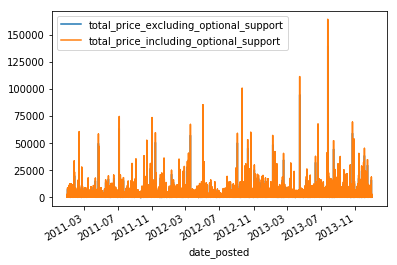

In [18]:
total_data.plot(x='date_posted', y = ['total_price_excluding_optional_support', 'total_price_including_optional_support'], kind = 'line' )
plt.show()

In [22]:
corr = ex.corr_table(total_data)

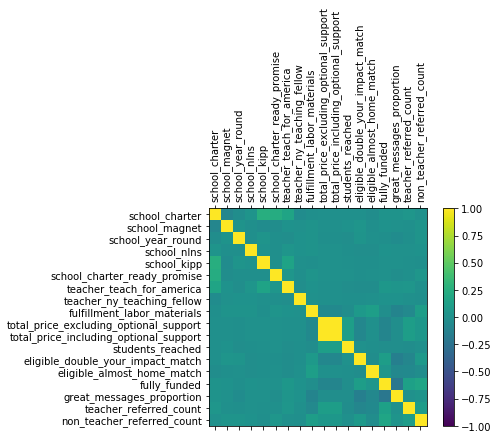

In [23]:
ex.plot_corr_matrix(corr)

In [77]:
total_data = gf.cat_to_dummy(total_data, ['school_metro','month', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject','teacher_prefix',
                                          'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'school_state', 'grade_level'])
                                        
                                          

In [54]:
total_data.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded,month,school_metro_rural,school_metro_suburban,school_metro_urban,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_subject_Applied Sciences,secondary_focus_subject_Character Education,secondary_focus_subject_Civics & Government,secondary_focus_subject_College & Career Prep,secondary_focus_subject_Community Service,secondary_focus_subject_ESL,secondary_focus_subject_Early Development,secondary_focus_subject_Economics,secondary_focus_subject_Environmental Science,secondary_focus_subject_Extracurricular,secondary_focus_subject_Foreign Languages,secondary_focus_subject_Gym & Fitness,secondary_focus_subject_Health & Life Science,secondary_focus_subject_Health & Wellness,secondary_focus_subject_History & Geography,secondary_focus_subject_Literacy,secondary_focus_subject_Literature & Writing,secondary_focus_subject_Mathematics,secondary_focus_subject_Music,secondary_focus_subject_Nutrition,secondary_focus_subject_Other,secondary_focus_subject_Parent Involvement,secondary_focus_subject_Performing Arts,secondary_focus_subject_Social Sciences,secondary_focus_subject_Special Needs,secondary_focus_subject_Sports,secondary_focus_subject_Visual Arts,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school

In [78]:
total_data = pp.drop_vars(total_data, ["school_state", "school_suburban", 'primary_focus_subject', 'month', 'primary_focus_area', 'secondary_focus_area',
                          'secondary_focus_subject', 'resource_type', 'poverty_level', 'grade_level', 'grade_level', 'teacher_prefix', 'school_metro'])

In [57]:
ex.dist_table(total_data)

,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,school_metro_rural,school_metro_suburban,school_metro_urban,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_subject_Applied Sciences,secondary_focus_subject_Character Education,secondary_focus_subject_Civics & Government,secondary_focus_subject_College & Career Prep,secondary_focus_subject_Community Service,secondary_focus_subject_ESL,secondary_focus_subject_Early Development,secondary_focus_subject_Economics,secondary_focus_subject_Environmental Science,secondary_focus_subject_Extracurricular,secondary_focus_subject_Foreign Languages,secondary_focus_subject_Gym & Fitness,secondary_focus_subject_Health & Life Science,secondary_focus_subject_Health & Wellness,secondary_focus_subject_History & Geography,secondary_focus_subject_Literacy,secondary_focus_subject_Literature & Writing,secondary_focus_subject_Mathematics,secondary_focus_subject_Music,secondary_focus_subject_Nutrition,secondary_focus_subject_Other,secondary_focus_subject_Parent Involvement,secondary_focus_subject_Performing Arts,secondary_focus_subject_Social Sciences,secondary_focus_subject_Special Needs,secondary_focus_subject_Sports,secondary_focus_subject_Visual Arts,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,schoo

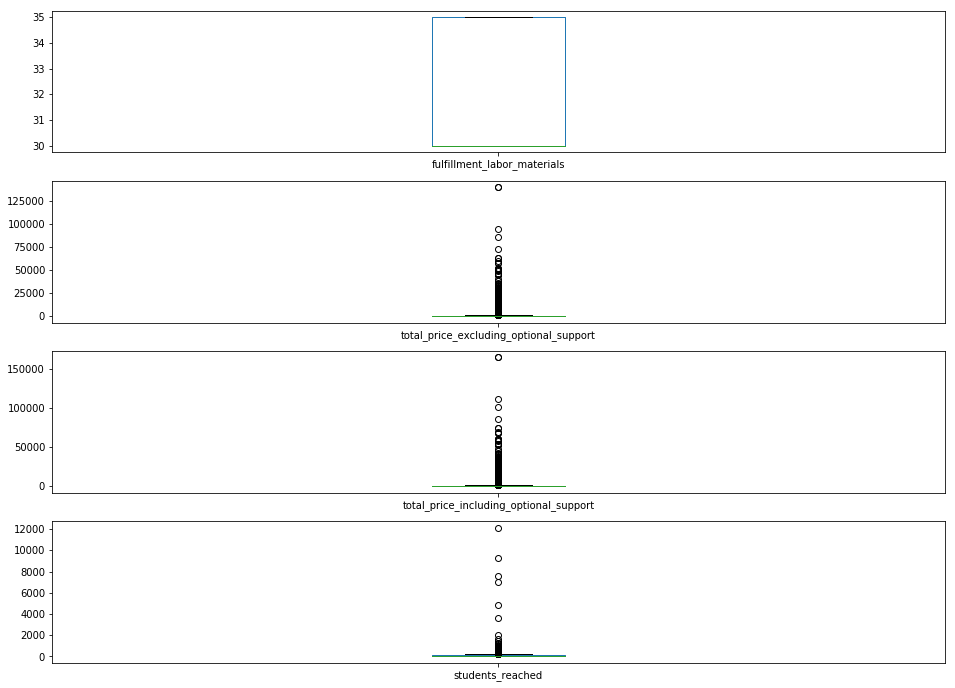

In [58]:
continuous_vars = ['fulfillment_labor_materials','total_price_excluding_optional_support', 
                   'total_price_including_optional_support', 'students_reached']

continuous_data = total_data[continuous_vars]

ex.outliers_plot(continuous_data)

KeyboardInterrupt: 

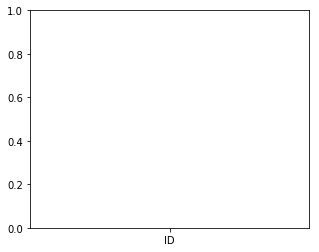

In [59]:
ex.plot_by_class(total_data, "fully_funded")

In [ ]:
corr_table = ex.corr_table(total_data)
ex.plot_y_corr(corr_table, "fully_funded")

In [ ]:
ex.plot_corr_matrix(corr_table)

In [79]:
Y = total_data['fully_funded']

In [101]:
Xn = pp.fill_missing_median(X)

In [102]:
Xn = Xn[Xn.isnull().any(axis=1)]

In [103]:
Xn

,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,school_metro_rural,school_metro_suburban,school_metro_urban,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_subject_Applied Sciences,secondary_focus_subject_Character Education,secondary_focus_subject_Civics & Government,secondary_focus_subject_College & Career Prep,secondary_focus_subject_Community Service,secondary_focus_subject_ESL,secondary_focus_subject_Early Development,secondary_focus_subject_Economics,secondary_focus_subject_Environmental Science,secondary_focus_subject_Extracurricular,secondary_focus_subject_Foreign Languages,secondary_focus_subject_Gym & Fitness,secondary_focus_subject_Health & Life Science,secondary_focus_subject_Health & Wellness,secondary_focus_subject_History & Geography,secondary_focus_subject_Literacy,secondary_focus_subject_Literature & Writing,secondary_focus_subject_Mathematics,secondary_focus_subject_Music,secondary_focus_subject_Nutrition,secondary_focus_subject_Other,secondary_focus_subject_Parent Involvement,secondary_focus_subject_Performing Arts,secondary_focus_subject_Social Sciences,secondary_focus_subject_Special Needs,secondary_focus_subject_Sports,secondary_focus_subject_Visual Arts,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,school_state_AK,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_ND,school_state_NE,school_state_NH,school_st

In [84]:
X = pp.drop_vars(total_data, ['fully_funded', 'school_metro', 'school_state'])

In [59]:
temp_split = tm.temporal_validate('2011-01-01', '2013-12-31', [6])

In [61]:
classifiers = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'LR': LogisticRegression(penalty='l1', C=1e5),
    'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'NB': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=3) 
        }

parameters = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }

test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}}

In [62]:
models_to_run = ['KNN', 'LR', 'DT']

In [87]:
tm.run_models(models_to_run, classifiers, test_grid, X, Y, temp_split, 'date_posted')

Running through model KNN...
{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
hi


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').